In [1]:
import pandas as pd
import numpy as np
from tokenize import generate_tokens
xrange = range
from io import StringIO
import matplotlib
import matplotlib.pyplot

In [2]:
# Helper funtions to process an array of strings from a csv

def parts(a):
    """Split a python-tokenizable expression on comma operators"""
    compos = [-1] # compos stores the positions of the relevant commas in the argument string
    compos.extend(t[2][1] for t in generate_tokens(StringIO(a).readline) if t[1] == ',')
    compos.append(len(a))
    return [ a[compos[i]+1:compos[i+1]] for i in xrange(len(compos)-1)]

#coverts to list of strings
def convertType(toConv, makeUpper):
    
    tcs = []
    for tc in toConv:
        tc = tc.replace('[','')
        tc = tc.replace(']','')
        tc = tc.replace('{','')
        tc = tc.replace('}','')
        tc = tc.replace(' \'','')
        tc = tc.replace('\'','')
        tc = tc.replace('@','')
        tc = tc.replace('-','')
        tc = tc.replace('#','')
        chain = parts(tc)
        
        chain2 = []
        for c in chain:
            chain2.append(c) 
        
        #make uppercase if specified
        chain3 = []
        if makeUpper:
            for c in chain2:
                chain3.append(c.upper())
            tcs.append(chain3)
        else:
            tcs.append(chain2)
        
    return np.array(tcs)

def fixDF(df):
    # remove empty columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # fix all string fields 
    for column in df:
        if (type(df[column][0]) == str):
            df[column] = convertType(df[column], False)
    
    return df 


In [3]:
# load in datasets
# load dataset and fix all string fields 

bills = pd.read_csv("bills_2019.csv")
bills = fixDF(bills)

legislators = pd.read_csv("legislators_2019.csv")
legislators = fixDF(legislators)

relationships = pd.read_csv("matrix_2019.csv")
relationships = fixDF(relationships)

c:\users\jagluck\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Bill Analysis ###

In [246]:
# 1 Introduced
# 2 Engrossed
# 3 Enrolled
# 4 Passed
# 5 Vetoed

In [247]:
len(bills)

2497

['bill_id', 'bill_number', 'change_hash', 'url', 'status_date', 'status', 'last_action_date', 'last_action', 'title', 'description', 'session_id', 'session_name', 'state_link', 'completed', 'state', 'state_id', 'bill_type', 'bill_type_id', 'bodie', 'body_id', 'current_body', 'current_body_id', 'pending_committee_id', 'progress_event', 'progress_date', 'history_date', 'history_action', 'history_chamber', 'history_chamber_id', 'history_importance', 'sponsor_people_id', 'sponsor_party_id', 'sponsor_party', 'sponsor_role_id', 'sponsor_role', 'sponsor_name', 'sponsor_district', 'sponsor_type_id', 'sponsor_order', 'committee_sponsor', 'votes_roll_call_id', 'votes_date', 'votes_desc', 'votes_yea', 'votes_nay', 'votes_nv', 'votes_absent', 'votes_total', 'votes_passed', 'votes_chamber', 'votes_chamber_id', 'votes_url', 'votes_state_link']
1    1373
3    848 
2    259 
4    17  
Name: status, dtype: int64


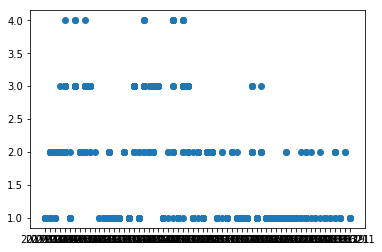

In [248]:
statuses = bills["status"]
print(list(bills))
print(statuses.value_counts())
matplotlib.pyplot.plot_date(bills["status_date"], bills["status"])

In [249]:
sp = bills['sponsor_party']
ps = []
for s in sp:
    ps.append(s[0])
unique, counts = np.unique(ps, return_counts=True)
print(dict(zip(unique, counts)))

{'': 262, 'D': 1672, 'R': 563}


In [250]:
passed_bills = bills[(bills["status"] == 4) | (bills["status"] == 3)]
print(len(passed_bills))

865


In [251]:
print(sum(legislators['primary_sponsored_bills_passed']))

864


In [252]:
pd.set_option('display.max_colwidth', -1)
n = 'Prince Georges County Delegation'
legislatorspg = legislators[legislators['name'] == n]
print(legislatorspg['primary_sponsored_bills'].sort_values())

148    [1168043,  1168000,  1167985,  1168038,  1167998,  1168014,  1168025,  1167966,  1168040,  1168061,  1168012,  1167971,  1168002,  1167994,  1168044,  1168042,  1167980,  1182345,  1182320,  1182323,  1184991,  1196438,  1196983,  1196548,  1209520,  1209526,  1209514,  1217191]
Name: primary_sponsored_bills, dtype: object


In [253]:
print(len(passed_bills))

865


In [254]:
print(len(bills))

2497


In [255]:
print(sum(legislators['primary_sponsored_bills_count']))

2496


In [256]:
bills_list = [1162064, 1164670, 1164690, 1164746, 1168029, 1175010, 1177768, 1180389, 1180322, 1180329, 1180298, 1182344, 1182290, 1184994, 1184933, 1188986, 1188962, 1188644, 1188923, 1188979, 1188629, 1188939, 1188708, 1188757, 1188697, 1188638, 1188680, 1188821, 1188602, 1188842, 1198196]

this_list = bills[bills["bill_id"].isin(bills_list)]
this_list["bill_number"]

1569    SB129
1578    SB138
1579    SB139
1591    SB151
1636    SB196
1708    SB268
1731    SB291
1751    SB311
1768    SB328
1769    SB329
1770    SB330
1794    SB354
1795    SB355
1881    SB441
1882    SB442
1991    SB551
1992    SB552
1993    SB553
2007    SB567
2129    SB689
2130    SB690
2131    SB691
2137    SB697
2176    SB736
2214    SB774
2244    SB804
2249    SB809
2252    SB812
2254    SB814
2257    SB817
2322    SB882
Name: bill_number, dtype: object

In [257]:
print(list(bills))

['bill_id', 'bill_number', 'change_hash', 'url', 'status_date', 'status', 'last_action_date', 'last_action', 'title', 'description', 'session_id', 'session_name', 'state_link', 'completed', 'state', 'state_id', 'bill_type', 'bill_type_id', 'bodie', 'body_id', 'current_body', 'current_body_id', 'pending_committee_id', 'progress_event', 'progress_date', 'history_date', 'history_action', 'history_chamber', 'history_chamber_id', 'history_importance', 'sponsor_people_id', 'sponsor_party_id', 'sponsor_party', 'sponsor_role_id', 'sponsor_role', 'sponsor_name', 'sponsor_district', 'sponsor_type_id', 'sponsor_order', 'committee_sponsor', 'votes_roll_call_id', 'votes_date', 'votes_desc', 'votes_yea', 'votes_nay', 'votes_nv', 'votes_absent', 'votes_total', 'votes_passed', 'votes_chamber', 'votes_chamber_id', 'votes_url', 'votes_state_link']


In [277]:
# find number of cross party co sponsorships

count = 0
all_count = 0
rtd = 0
dtr = 0
rtr = 0
dtd = 0
for index,row in bills.iterrows():
    if (len(row['sponsor_party']) > 1):
        main = row['sponsor_party'][0]
        if (main.strip() == "R" or main.strip() == "D"):
            sps = row['sponsor_party']
            sps = sps[1:]
            for cp in sps:
                if (cp.strip() == "R" or cp.strip() == "D"):
                    all_count = all_count + 1
                    if (cp.strip() != main.strip()):
                        count = count + 1
                        if (cp.strip() == "D"):
                            dtr = dtr + 1
                        if (cp.strip() == "R"):
                            rtd = rtd + 1
                    else:
                        count = count + 1
                        if (cp.strip() == "D"):
                            dtd = dtd + 1
                        if (cp.strip() == "R"):
                            rtr = rtr + 1
print(count)
print(all_count)
print(rtd)
print(dtr)
print(rtr)
print(dtd)

15618
15618
2248
622
2181
10567


In [ ]:
for i in bills['']

In [278]:
# legislators = legislators[["name","party","primary_sponsored_bills_passed","primary_sponsored_bills_count","primary_sponsored_bills_avg","co_sponsored_bills_avg","co_sponsored_bills_count", "co_sponsored_bills_passed", "committee_sponsor","people_id"]]
# legislators = legislators[legislators['committee_sponsor'] != 1]

print(sum(legislators['co_sponsored_bills_count']))

15649


In [260]:
print(bills['sponsor_party'])

0       [D]                                                                           
1       [D]                                                                           
2       [D]                                                                           
3       [D]                                                                           
4       [D, D, D, D, D, D, R, R, R, D, D, D, D, D, R, D, D, D, D, R, R, D, D, D, R]   
5       [D]                                                                           
6       [D]                                                                           
7       [D]                                                                           
8       [D]                                                                           
9       [D]                                                                           
10      [D, D, D, D, R, R, D, D, D, R, D, D]                                          
11      [R, R]                             

In [111]:
print(list(legislators))

['name', 'party', 'district', 'role', 'people_id', 'committee_sponsor', 'all_sponsored_bills_count', 'unspecified_sponsored_bills_count', 'primary_sponsored_bills_count', 'co_sponsored_bills_count', 'joint_sponsored_bills_count', 'all_sponsored_bills', 'unspecified_sponsored_bills', 'primary_sponsored_bills', 'co_sponsored_bills', 'joint_sponsored_bills', 'all_sponsored_bills_status', 'unspecified_sponsored_bills_status', 'primary_sponsored_bills_status', 'co_sponsored_bills_status', 'joint_sponsored_bills_status', 'all_sponsored_bills_passed', 'unspecified_sponsored_bills_passed', 'primary_sponsored_bills_passed', 'co_sponsored_bills_passed', 'joint_sponsored_bills_passed', 'all_sponsored_bills_avg', 'unspecified_sponsored_bills_avg', 'primary_sponsored_bills_avg', 'co_sponsored_bills_avg', 'joint_sponsored_bills_avg']


### Legislator Analysis ###

In [279]:
# Best Primary Bill AVG
sm = legislators[["name","party","primary_sponsored_bills_passed","primary_sponsored_bills_count","primary_sponsored_bills_avg","co_sponsored_bills_avg","co_sponsored_bills_count", "co_sponsored_bills_passed", "committee_sponsor","people_id"]]
sm = sm[sm['committee_sponsor'] != 1]
sm = sm.sort_values(by=['primary_sponsored_bills_avg', 'primary_sponsored_bills_count'], ascending=[False,False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_avg"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_avg"])))
sm.head(50)

mean: 0.3057712884499195
median: 0.26666666666666666


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Melony Griffith,D,13,13,1.000000,0.604167,48,29,0,4664
1,Maggie McIntosh,D,5,5,1.000000,0.434783,69,30,0,4649
2,Jerry Clark,R,4,4,1.000000,0.157143,70,11,0,19026
3,Charles Otto,R,4,4,1.000000,0.138462,65,9,0,12078
4,Heather Bagnall,D,3,3,1.000000,0.571429,105,60,0,20588
5,Jesse Pippy,R,3,3,1.000000,0.310345,29,9,0,20534
6,Andrea Harrison,D,1,1,1.000000,0.488372,43,21,0,21279
7,Brian Chisholm,R,1,1,1.000000,0.373913,115,43,0,20530
8,Jessica Feldmark,D,1,1,1.000000,0.435294,85,37,0,20860
9,Courtney Watson,D,1,1,1.000000,0.440000,50,22,0,20857


In [280]:
sm.to_csv("legislators_sm_2019.csv")

In [281]:
# worst Primary Bill AVG
sm = sm.sort_values(by=['primary_sponsored_bills_avg',"primary_sponsored_bills_count"], ascending=[True,False]).reset_index(drop=True)
sm.head(30)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Neil Parrott,R,0,16,0.0,0.092308,65,6,0,12189
1,April Rose,R,0,12,0.0,0.204301,93,19,0,17670
2,Bob Cassilly,R,0,11,0.0,0.283582,67,19,0,17244
3,Jason Buckel,R,0,10,0.0,0.216667,120,26,0,17231
4,Mary Ann Lisanti,D,0,10,0.0,0.430556,72,31,0,17442
5,Mark Chang,D,0,9,0.0,0.381579,76,29,0,17233
6,Frank Conaway,D,0,8,0.0,0.500000,58,29,0,4531
7,Bob Long,R,0,8,0.0,0.200000,50,10,0,17424
8,Johnny Mautz,R,0,8,0.0,0.174603,63,11,0,17425
9,Vaughn Stewart,D,0,7,0.0,0.320513,156,50,0,20797


In [282]:
# most primary sponsors passed
sm = sm.sort_values(by=['primary_sponsored_bills_passed'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_passed"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_passed"])))
sm.head(20)

mean: 3.606382978723404
median: 3.0


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Thomas Miller,D,17,52,0.326923,0.750000,20,15,0,4700
1,Brian Feldman,D,16,22,0.727273,0.573913,115,66,0,4575
2,Michael Busch,D,16,50,0.320000,0.727273,11,8,0,4569
3,Paul Pinsky,D,14,26,0.538462,0.508772,57,29,0,4725
4,Antonio Hayes,D,14,33,0.424242,0.520833,96,50,0,17321
5,Ronald Young,D,13,30,0.433333,0.439394,132,58,0,11711
6,William Smith,D,13,40,0.325000,0.496124,129,64,0,17171
7,Melony Griffith,D,13,13,1.000000,0.604167,48,29,0,4664
8,Clarence Lam,D,12,44,0.272727,0.536082,97,52,0,17170
9,Benjamin Kramer,D,12,27,0.444444,0.492537,67,33,0,4597


In [283]:
# least primary sponsors passed
sm = sm.sort_values(by=['primary_sponsored_bills_passed'], ascending=[True]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_passed"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_passed"])))
sm.head(50)

mean: 3.606382978723404
median: 3.0


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Neil Parrott,R,0,16,0.000000,0.092308,65,6,0,12189
1,Bob Cassilly,R,0,11,0.000000,0.283582,67,19,0,17244
2,Jason Buckel,R,0,10,0.000000,0.216667,120,26,0,17231
3,Mary Ann Lisanti,D,0,10,0.000000,0.430556,72,31,0,17442
4,Mark Chang,D,0,9,0.000000,0.381579,76,29,0,17233
5,Bob Long,R,0,8,0.000000,0.200000,50,10,0,17424
6,Johnny Mautz,R,0,8,0.000000,0.174603,63,11,0,17425
7,Vaughn Stewart,D,0,7,0.000000,0.320513,156,50,0,20797
8,Frank Conaway,D,0,8,0.000000,0.500000,58,29,0,4531
9,Gabriel Acevero,D,0,7,0.000000,0.306569,137,42,0,20789


In [284]:
print(len(sm))

188


In [285]:
# most primary sponsors attempted
sm = sm.sort_values(by=['primary_sponsored_bills_count'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_count"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_count"])))
sm.head(30)

mean: 11.882978723404255
median: 10.0


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Thomas Miller,D,17,52,0.326923,0.750000,20,15,0,4700
1,Michael Busch,D,16,50,0.320000,0.727273,11,8,0,4569
2,Clarence Lam,D,12,44,0.272727,0.536082,97,52,0,17170
3,Katherine Klausmeier,D,9,43,0.209302,0.500000,76,38,0,4686
4,Jill Carter,D,7,43,0.162791,0.510417,96,49,0,4584
5,William Smith,D,13,40,0.325000,0.496124,129,64,0,17171
6,Susan Lee,D,12,37,0.324324,0.500000,124,62,0,4626
7,Antonio Hayes,D,14,33,0.424242,0.520833,96,50,0,17321
8,Chris West,R,6,32,0.187500,0.361538,130,47,0,17243
9,Ronald Young,D,13,30,0.433333,0.439394,132,58,0,11711


In [286]:
# least primary sponsors attempted
sm = sm.sort_values(by=['primary_sponsored_bills_count'], ascending=[True]).reset_index(drop=True)
sm.head(70)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Jen Terrasa,D,0,0,0.000000,0.387755,98,38,0,20868
1,Debra Davis,D,0,0,0.000000,0.457143,35,16,0,20859
2,Jay Jalisi,D,0,0,0.000000,0.355556,90,32,0,17169
3,Dalya Attar,D,0,1,0.000000,0.411765,34,14,0,20930
4,Jessica Feldmark,D,1,1,1.000000,0.435294,85,37,0,20860
5,Nick Charles,D,0,1,0.000000,0.656250,96,63,0,20931
6,Lauren Arikan,R,0,1,0.000000,0.244681,94,23,0,20964
7,Wayne Hartman,R,0,1,0.000000,0.237288,59,14,0,20533
8,Elizabeth Proctor,D,0,1,0.000000,0.428571,56,24,0,17833
9,Tawanna Gaines,D,0,1,0.000000,0.490566,53,26,0,4660


In [287]:
# most co sponsors passed
sm = sm.sort_values(by=['co_sponsored_bills_passed'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["co_sponsored_bills_passed"])))
print("median: " + str(np.median(sm["co_sponsored_bills_passed"])))
sm.head(10)

mean: 32.962765957446805
median: 31.5


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Robbyn Lewis,D,4,10,0.400000,0.442308,208,92,0,18731
1,Joseline PenaMelnyk,D,5,8,0.625000,0.496503,143,71,0,4561
2,Erek Barron,D,9,25,0.360000,0.507143,140,71,0,17319
3,Terri Hill,D,4,20,0.200000,0.554688,128,71,0,17167
4,Ariana Kelly,D,7,11,0.636364,0.450331,151,68,0,11634
5,Brian Feldman,D,16,22,0.727273,0.573913,115,66,0,4575
6,Mary Washington,D,3,16,0.187500,0.455172,145,66,0,11917
7,Brooke Lierman,D,7,18,0.388889,0.458333,144,66,0,17237
8,Karen Young,D,3,13,0.230769,0.585586,111,65,0,17248
9,William Smith,D,13,40,0.325000,0.496124,129,64,0,17171


In [288]:
# least co sponsors passed
sm = sm.sort_values(by=['co_sponsored_bills_passed'], ascending=[True]).reset_index(drop=True)
sm.head(10)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Nino Mangione,R,0,2,0.000000,0.053571,56,3,0,20933
1,Mark Fisher,R,0,7,0.000000,0.100000,30,3,0,11554
2,Richard Impallaria,R,0,4,0.000000,0.181818,22,4,0,4638
3,Neil Parrott,R,0,16,0.000000,0.092308,65,6,0,12189
4,William Wivell,R,1,9,0.111111,0.189189,37,7,0,17669
5,Mike Rogers,D,2,3,0.666667,0.194444,36,7,0,20592
6,Seth Howard,R,2,9,0.222222,0.148936,47,7,0,17324
7,Warren Miller,R,4,10,0.400000,0.190476,42,8,0,11771
8,Michael Busch,D,16,50,0.320000,0.727273,11,8,0,4569
9,Carl Anderton,R,0,2,0.000000,0.204545,44,9,0,17419


In [289]:
# AVG co sponsors highest
sm = sm.sort_values(by=['co_sponsored_bills_avg'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["co_sponsored_bills_avg"])))
print("median: " + str(np.median(sm["co_sponsored_bills_avg"])))
sm.head(10)

mean: 0.39567678453687233
median: 0.4108003857280617


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Thomas Miller,D,17,52,0.326923,0.750000,20,15,0,4700
1,Michael Busch,D,16,50,0.320000,0.727273,11,8,0,4569
2,Nick Charles,D,0,1,0.000000,0.656250,96,63,0,20931
3,Harry Bhandari,D,1,4,0.250000,0.654545,55,36,0,20790
4,Shane Pendergrass,D,4,5,0.800000,0.653846,78,51,0,4635
5,Samuel Rosenberg,D,3,29,0.103448,0.651685,89,58,0,4581
6,William Ferguson,D,10,17,0.588235,0.644737,76,49,0,11453
7,Ken Kerr,D,2,5,0.400000,0.644444,90,58,0,20792
8,Robert Zirkin,D,3,25,0.120000,0.619048,42,26,0,4713
9,Melony Griffith,D,13,13,1.000000,0.604167,48,29,0,4664


In [290]:
# AVG co sponsors lowest
sm = sm.sort_values(by=['co_sponsored_bills_avg'], ascending=[True]).reset_index(drop=True)
sm.head(10)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Nino Mangione,R,0,2,0.000000,0.053571,56,3,0,20933
1,Neil Parrott,R,0,16,0.000000,0.092308,65,6,0,12189
2,Mark Fisher,R,0,7,0.000000,0.100000,30,3,0,11554
3,Charles Otto,R,4,4,1.000000,0.138462,65,9,0,12078
4,Barrie Ciliberti,R,0,5,0.000000,0.147059,68,10,0,17553
5,Seth Howard,R,2,9,0.222222,0.148936,47,7,0,17324
6,Steven Arentz,R,1,4,0.250000,0.150685,73,11,0,16083
7,Jerry Clark,R,4,4,1.000000,0.157143,70,11,0,19026
8,Jay Jacobs,R,2,7,0.285714,0.171429,70,12,0,11449
9,Haven Shoemaker,R,1,9,0.111111,0.172727,110,19,0,17427


In [291]:
# co sponsors count most
sm = sm.sort_values(by=['co_sponsored_bills_count'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["co_sponsored_bills_count"])))
print("median: " + str(np.median(sm["co_sponsored_bills_count"])))
sm.head(10)

mean: 83.10106382978724
median: 77.5


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Robbyn Lewis,D,4,10,0.400000,0.442308,208,92,0,18731
1,David Moon,D,6,22,0.272727,0.284024,169,48,0,17238
2,Vaughn Stewart,D,0,7,0.000000,0.320513,156,50,0,20797
3,Ariana Kelly,D,7,11,0.636364,0.450331,151,68,0,11634
4,Jheanelle Wilkins,D,5,15,0.333333,0.357616,151,54,0,19199
5,Susan Krebs,R,4,14,0.285714,0.324324,148,48,0,4629
6,Mary Washington,D,3,16,0.187500,0.455172,145,66,0,11917
7,Brooke Lierman,D,7,18,0.388889,0.458333,144,66,0,17237
8,Joseline PenaMelnyk,D,5,8,0.625000,0.496503,143,71,0,4561
9,Julian Ivey,D,1,15,0.066667,0.375887,141,53,0,20791


In [292]:
# co sponsors count least
sm = sm.sort_values(by=['co_sponsored_bills_count'], ascending=[True]).reset_index(drop=True)
sm.head(10)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Michael Busch,D,16,50,0.320000,0.727273,11,8,0,4569
1,Thomas Miller,D,17,52,0.326923,0.750000,20,15,0,4700
2,Luke Clippinger,D,4,7,0.571429,0.550000,20,11,0,11447
3,Richard Impallaria,R,0,4,0.000000,0.181818,22,4,0,4638
4,Jesse Pippy,R,3,3,1.000000,0.310345,29,9,0,20534
5,Mark Fisher,R,0,7,0.000000,0.100000,30,3,0,11554
6,Talmadge Branch,D,1,4,0.250000,0.515152,33,17,0,4602
7,Dalya Attar,D,0,1,0.000000,0.411765,34,14,0,20930
8,Debra Davis,D,0,0,0.000000,0.457143,35,16,0,20859
9,Mike Rogers,D,2,3,0.666667,0.194444,36,7,0,20592


In [293]:
# Split by party

Rdel = sm.loc[sm['party'] == "R"]
Ddel = sm.loc[sm['party'] == "D"]

print("# of rep deligates: " + str(len(Rdel)))
print("# of dem deligates: " + str(len(Ddel)))
print("\n")

# primary counts
print("Rep primary count mean: " + str(np.mean(Rdel["primary_sponsored_bills_count"])))
print("Rep primary count median: " + str(np.median(Rdel["primary_sponsored_bills_count"])))
print("Dem primary count mean: " + str(np.mean(Ddel["primary_sponsored_bills_count"])))
print("Dem primary count median: " + str(np.median(Ddel["primary_sponsored_bills_count"])))
print("\n")

# Primary Bill AVG
print("Rep primary bill avg mean: " + str(np.mean(Rdel["primary_sponsored_bills_avg"])))
print("Rep primary bill avg median: " + str(np.median(Rdel["primary_sponsored_bills_avg"])))
print("Dem primary bill avg mean: " + str(np.mean(Ddel["primary_sponsored_bills_avg"])))
print("Dem primary bill avg median: " + str(np.median(Ddel["primary_sponsored_bills_avg"])))
print("\n")

# Primary Bill AVG
print("Rep primary bills passed mean: " + str(np.mean(Rdel["primary_sponsored_bills_passed"])))
print("Rep primary bills passed median: " + str(np.median(Rdel["primary_sponsored_bills_passed"])))
print("Dem primary bills passed mean: " + str(np.mean(Ddel["primary_sponsored_bills_passed"])))
print("Dem primary bills passed median: " + str(np.median(Ddel["primary_sponsored_bills_passed"])))
print("\n")

# of rep deligates: 57
# of dem deligates: 131


Rep primary count mean: 9.859649122807017
Rep primary count median: 9.0
Dem primary count mean: 12.763358778625955
Dem primary count median: 10.0


Rep primary bill avg mean: 0.22960050405802945
Rep primary bill avg median: 0.16666666666666666
Dem primary bill avg mean: 0.33891430150593277
Dem primary bill avg median: 0.3043478260869565


Rep primary bills passed mean: 2.1403508771929824
Rep primary bills passed median: 1.0
Dem primary bills passed mean: 4.244274809160306
Dem primary bills passed median: 3.0




### Relationships Analysis ###

In [294]:
print(list(legislators))

['name', 'party', 'district', 'role', 'people_id', 'committee_sponsor', 'all_sponsored_bills_count', 'unspecified_sponsored_bills_count', 'primary_sponsored_bills_count', 'co_sponsored_bills_count', 'joint_sponsored_bills_count', 'all_sponsored_bills', 'unspecified_sponsored_bills', 'primary_sponsored_bills', 'co_sponsored_bills', 'joint_sponsored_bills', 'all_sponsored_bills_status', 'unspecified_sponsored_bills_status', 'primary_sponsored_bills_status', 'co_sponsored_bills_status', 'joint_sponsored_bills_status', 'all_sponsored_bills_passed', 'unspecified_sponsored_bills_passed', 'primary_sponsored_bills_passed', 'co_sponsored_bills_passed', 'joint_sponsored_bills_passed', 'all_sponsored_bills_avg', 'unspecified_sponsored_bills_avg', 'primary_sponsored_bills_avg', 'co_sponsored_bills_avg', 'joint_sponsored_bills_avg']


In [295]:
# most cosponsers

print(list(relationships))

relationships = relationships.sort_values(by=['co_bills_total'], ascending=False)
rsm = relationships[["first_name","second_name","co_bills_total", "co_bills_status","co_bills"]]
rsm = rsm.sort_values(by=['co_bills_total'], ascending=False)
rsm.head(40)

['relationship', 'first_name', 'second_name', 'co_bills', 'co_bills_status', 'co_bills_total']


,first_name,second_name,co_bills_total,co_bills_status,co_bills
0,Susan Lee,William Smith,31,"[3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 3, 3, 3, 2, 3, 1, 1, 1, 1]","[1162064, 1164670, 1164690, 1164746, 1168029, 1175010, 1177768, 1180389, 1180322, 1180329, 1180298, 1182344, 1182290, 1184994, 1184933, 1188986, 1188962, 1188644, 1188923, 1188979, 1188629, 1188939, 1188708, 1188757, 1188697, 1188638, 1188680, 1188821, 1188602, 1188842, 1198196]"
1,Kathy Szeliga,Michael Busch,25,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3]","[1147697, 1147689, 1147682, 1147691, 1167661, 1167619, 1167402, 1167640, 1167381, 1167488, 1167467, 1167446, 1167575, 1167997, 1170390, 1170270, 1170178, 1170404, 1170324, 1170465, 1170151, 1188814, 1194036, 1194034, 1243029]"
2,Chris West,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164758, 1164634, 1164742, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1196639, 1196860]"
6,Adelaide Eckardt,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164758, 1164634, 1164742, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1196639, 1196860]"
7,Mary Carozza,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164758, 1164634, 1164742, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1196639, 1196860]"
5,Michael Busch,Ric Metzgar,24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3]","[1147697, 1147689, 1147682, 1147691, 1167661, 1167619, 1167402, 1167423, 1167640, 1167381, 1167488, 1167467, 1167446, 1167575, 1167997, 1170390, 1170270, 1170178, 1170404, 1170324, 1170465, 1170151, 1188814, 1243029]"
4,Michael Busch,Nicholaus Kipke,24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3]","[1147697, 1147689, 1147682, 1147691, 1167661, 1167619, 1167402, 1167640, 1167381, 1167488, 1167467, 1167446, 1167575, 1167997, 1170390, 1170270, 1170178, 1170404, 1170324, 1170465, 1170151, 1188814, 1188713, 1243029]"
9,Brian Chisholm,Michael Busch,24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3]","[1147697, 1147689, 1147682, 1147691, 1167661, 1167619, 1167402, 1167640, 1167381, 1167488, 1167467, 1167446, 1167575, 1167997, 1170390, 1170270, 1170178, 1170404, 1170465, 1170151, 1188814, 1194036, 1194034, 1243029]"
8,Jack Bailey,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164634, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1188674, 1196639, 1196860, 1208187]"
3,Jason Gallion,Thomas Miller,24,"[2, 1, 1, 1, 3, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1162264, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164758, 1164634, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1196639, 1196860]"


In [296]:
# least cosponsers
print("Reationships with no cosponserships: " + str(len(rsm.loc[rsm['co_bills_total'] == 0])))
print("Reationships with at least 1 cosponsership: " + str(len(rsm.loc[rsm['co_bills_total'] != 0])))

Reationships with no cosponserships: 20515
Reationships with at least 1 cosponsership: 5363


In [58]:
nt = legislators[legislators['committee_sponsor'] != 1]
nt = nt[["name","party"]]

group = []
for i in nt['party']:
    if (i == "D"):
        group.append(1)
    else:
        group.append(2)
        
nt['group'] = group
nt = nt.drop(columns=['party'])

nt.rename(columns={'name':'id'}, inplace=True)

In [59]:
json = nt.to_json(orient='records')
print(json)

[{"id":"Stephen Lafferty","group":1},{"id":"Cheryl Glenn","group":1},{"id":"Alfred Carr","group":1},{"id":"Mark Chang","group":1},{"id":"Eric Ebersole","group":1},{"id":"Vanessa Atterbeary","group":1},{"id":"Dalya Attar","group":1},{"id":"Kumar Barve","group":1},{"id":"Regina Boyce","group":1},{"id":"Tony Bridges","group":1},{"id":"Andrew Cassilly","group":2},{"id":"Barrie Ciliberti","group":2},{"id":"Jerry Clark","group":2},{"id":"David Fraserhidalgo","group":1},{"id":"James Gilchrist","group":1},{"id":"Andrea Harrison","group":1},{"id":"Anne Healey","group":1},{"id":"Marvin Holmes","group":1},{"id":"Jay Jacobs","group":2},{"id":"Jay Jalisi","group":1},{"id":"Mary Lehman","group":1},{"id":"Sara Love","group":1},{"id":"Charles Otto","group":2},{"id":"Neil Parrott","group":2},{"id":"Dana Stein","group":1},{"id":"Vaughn Stewart","group":1},{"id":"Melissa Wells","group":1},{"id":"William Wivell","group":2},{"id":"Brooke Lierman","group":1},{"id":"Charles Sydnor","group":1},{"id":"Curtis A

In [4]:
print(list(relationships))

['relationship', 'first_name', 'second_name', 'co_bills', 'co_bills_status', 'co_bills_total']


In [5]:
rl = relationships[['first_name', 'second_name', 'co_bills_total']]
rl.rename(columns={'name':'source', 'second_name' : 'target', 'co_bills_total' : 'value'}, inplace=True)

c:\users\jagluck\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [7]:
json = rl.to_json(orient='records')
print(json)

[{"first_name":"Susan Lee","target":"William Smith","value":31},{"first_name":"Kathy Szeliga","target":"Michael Busch","value":25},{"first_name":"Chris West","target":"Thomas Miller","value":24},{"first_name":"Mary Carozza","target":"Thomas Miller","value":24},{"first_name":"Jason Gallion","target":"Thomas Miller","value":24},{"first_name":"Jack Bailey","target":"Thomas Miller","value":24},{"first_name":"Brian Chisholm","target":"Michael Busch","value":24},{"first_name":"Adelaide Eckardt","target":"Thomas Miller","value":24},{"first_name":"Michael Busch","target":"Ric Metzgar","value":24},{"first_name":"Michael Busch","target":"Nicholaus Kipke","value":24},{"first_name":"George Edwards","target":"Thomas Miller","value":23},{"first_name":"Michael Busch","target":"Sid Saab","value":23},{"first_name":"Michael Hough","target":"Thomas Miller","value":23},{"first_name":"Stephen Hershey","target":"Thomas Miller","value":23},{"first_name":"Matt Morgan","target":"Michael Busch","value":23},{"fi